# Data visualization

In [1]:
import data_processing as dp
import training as trn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons, CheckButtons

from create_model import predictand_std_data
%matplotlib widget
plt.close("all")

## Load a dataset and model

In [66]:
# Name of dataset and model to load
dataset_name = "test"
model_name = "test"

vis_df = dp.read_processed_csv(dataset_name)
network, rmse_timeline = dp.read_model_json(model_name)

# Calculate the actual vs predicted values for the trained model
outcome_df = vis_df.loc[["trn", "val", "test"]]
outcome_df = pd.DataFrame(data=trn.predict(network, outcome_df),
                         index=outcome_df.index)
predictand_std_data = vis_df.loc["meta_std"].iloc[:, -1]
outcome_df = dp.destd_predictands_range(outcome_df, predictand_std_data).iloc[:, 0]

vis_df = dp.destd_range(vis_df)
real_vals = vis_df.droplevel(level=0, axis=1)["p"]
outcome_df = pd.concat([real_vals, outcome_df], axis=1, keys=["Actual", "Modelled"])

Loading processed data from datasets/processed/test.csv
Loading model from models/test.json


## Graphs

### Plot data by type and cull by std devs

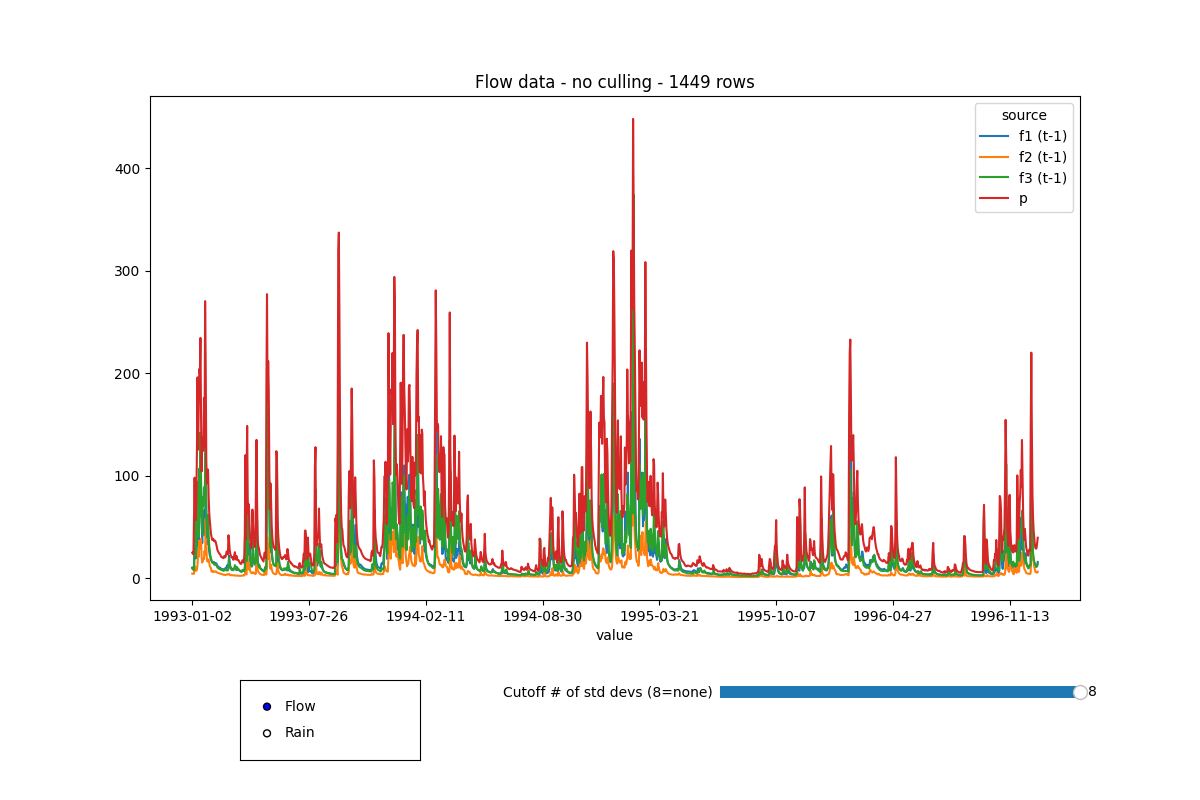

In [44]:
plt.close("all")
std_df = vis_df.droplevel(level=0).sort_index()

# ============================ GRAPH ==================================


# Line graph showing flow/rain datasets after culling with different std dev values

# Initial graph - flow data with no culling
fig, ax_graph = plt.subplots()
ax_buttons = fig.add_axes([0.2, 0.05, 0.15, 0.1])
ax_slider = fig.add_axes([0.6, 0.12, 0.3, 0.03])
std_df["f"].plot(ax=ax_graph,
    title=f"Flow data - no culling - {std_df.shape[0]} rows")



# ============================== COMPONENTS ================================


# Radio buttons for flow/rain

dataset_radio = RadioButtons(ax=ax_buttons, labels=["Flow", "Rain"])



# Slider for # of std devs

sd_slider = Slider(ax=ax_slider, label="Cutoff # of std devs (8=none)",
                   valmin=1, valmax=8, valinit=8, valstep=1)

# ======================== EVENT HANDLER FUNCTIONS =======================

def std_update(val):
    data_type = dataset_radio.value_selected
    sd = sd_slider.val

    std_data = std_df.copy()
    title_text = f"{data_type} data - no culling - {std_data.shape[0]} rows"
    if sd != 8:
        std_data = std_data[np.abs(std_data - std_data.std()) <= std_data.mean() + sd * std_data.std()]
        std_data.dropna(inplace=True)
        title_text = f"{data_type} data - culling values >{sd} std devs from mean - {std_data.shape[0]} rows"

    ax_graph.clear()

    dt = data_type[0].lower()
    if dt == "f":
        std_ax_data = std_data.loc[:, dt]
    else:
        std_ax_data = std_data[[c for c in std_data if c[1][0] != "f"]]
        std_ax_data = std_ax_data.droplevel(level=0, axis=1)
    std_ax_data.plot(ax=ax_graph, title=title_text)
    fig.subplots_adjust(bottom=0.25)
    fig.canvas.draw()


dataset_radio.on_clicked(std_update)
sd_slider.on_changed(std_update)

# Figure styling
fig.subplots_adjust(bottom=0.25)
fig.set_size_inches((12, 8))
fig.canvas.header_visible = False

### Plot predictand against predictors with transformations

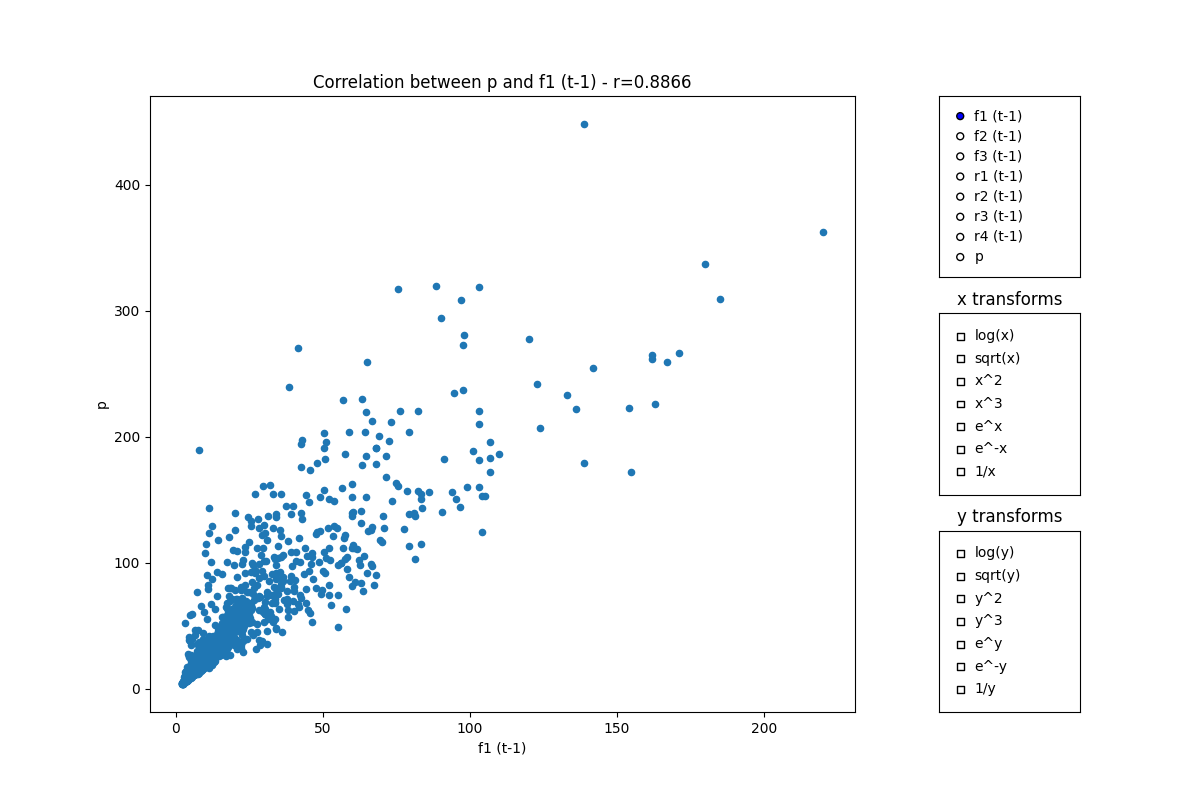

In [45]:
plt.close("all")
corr_data = vis_df.droplevel(level=0, axis=1)

# ============================ GRAPHS ==================================


# Line graph showing flow/rain datasets after culling with different std dev values

# Initial graph - flow data with no culling
corr_fig, corr_axes = plt.subplot_mosaic(
    [
        ["main", "xdata"],
        ["main", "x_transforms"],
        ["main", "y_transforms"],
    ],
    width_ratios=[5, 1])
corr_axes["x_transforms"].set_title("x transforms")
corr_axes["y_transforms"].set_title("y transforms")

pd_init_x = corr_data.columns[0]
corr_init = corr_data.corr()["p"][pd_init_x]
corr_data.plot(x=pd_init_x, y="p", kind="scatter", ax=corr_axes["main"],
               title=f"Correlation between p and {pd_init_x} - r={corr_init:.4f}")

# ============================== COMPONENTS ================================


# Radio buttons for predictor to plot

predictor_radio = RadioButtons(ax=corr_axes["xdata"],
                               labels=corr_data.columns)

# Check buttons for predictor transforms

def transform_labels(axis):
    return [f"log({axis})",
            f"sqrt({axis})",
            f"{axis}^2",
            f"{axis}^3",
            f"e^{axis}",
            f"e^-{axis}",
            f"1/{axis}",]

x_transform_checks = CheckButtons(ax=corr_axes["x_transforms"],
                                labels=transform_labels("x"))


# Check buttons for predictand transforms

y_transform_checks = CheckButtons(ax=corr_axes["y_transforms"],
                                  labels=transform_labels("y"))

# ======================== EVENT HANDLER FUNCTIONS =======================

def apply_transforms(checks, dat):
    transforms = checks.get_status()
    if transforms[0]: dat = dat.apply(np.log)
    if transforms[1]: dat = dat.apply(np.sqrt)
    if transforms[2]: dat = dat.apply(np.square)
    if transforms[3]: dat = dat.apply(lambda x: np.power(x, 3))
    if transforms[4]: dat = dat.apply(lambda x: np.power(np.e, x))
    if transforms[5]: dat = dat.apply(lambda x: np.power(np.e, -x))
    if transforms[6]: dat = dat.apply(lambda x: 1 / x if x != 0 else 0)
    return dat

def pd_update(val):
    prd = predictor_radio.value_selected

    c_data = corr_data.copy()

    c_data[prd] = apply_transforms(x_transform_checks, c_data[prd])
    c_data["p"] = apply_transforms(y_transform_checks, c_data["p"])

    corr = c_data.corr()["p"][prd]

    corr_axes["main"].clear()
    c_data.plot(x=prd, y="p", kind="scatter", ax=corr_axes["main"],
                title=f"Correlation between p and {prd} - r={corr:.4f}")
    corr_fig.canvas.draw()

predictor_radio.on_clicked(pd_update)
x_transform_checks.on_clicked(pd_update)
y_transform_checks.on_clicked(pd_update)

# Figure styling
corr_fig.set_size_inches((12, 8))
corr_fig.canvas.header_visible = False

### Heatmap of correlations between all columns

In [46]:
heatmap_df = vis_df.droplevel(level=0, axis=1).corr()
heatmap_df.style.background_gradient(cmap='Blues')

source,f1 (t-1),f2 (t-1),f3 (t-1),r1 (t-1),r2 (t-1),r3 (t-1),r4 (t-1),p
source,,,,,,,,
f1 (t-1),1.000000,0.931568,0.898979,0.329366,0.238756,0.306136,0.365255,0.886649
f2 (t-1),0.931568,1.000000,0.865723,0.370758,0.257217,0.325094,0.364167,0.885243
f3 (t-1),0.898979,0.865723,1.000000,0.471403,0.294261,0.480385,0.556395,0.913416
r1 (t-1),0.329366,0.370758,0.471403,1.000000,0.601168,0.595872,0.635101,0.507140
r2 (t-1),0.238756,0.257217,0.294261,0.601168,1.000000,0.439301,0.423620,0.340427
r3 (t-1),0.306136,0.325094,0.480385,0.595872,0.439301,1.000000,0.687929,0.491666
r4 (t-1),0.365255,0.364167,0.556395,0.635101,0.423620,0.687929,1.000000,0.580775
p,0.886649,0.885243,0.913416,0.507140,0.340427,0.491666,0.580775,1.000000


### RMSE of model during training (currently not working)

Text(0, 0.5, 'Root MSE')

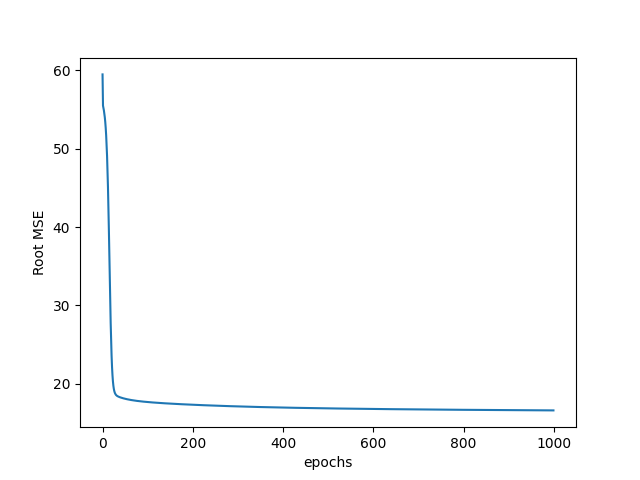

In [47]:
plt.close("all")

rmse_fig, rmse_ax_graph = plt.subplots()

rmse_ax_graph.plot(rmse_timeline)

plt.xlabel("epochs")
plt.ylabel("Root MSE")

### Line graph of predicted and modelled values with time

Text(0, 0.5, 'Value')

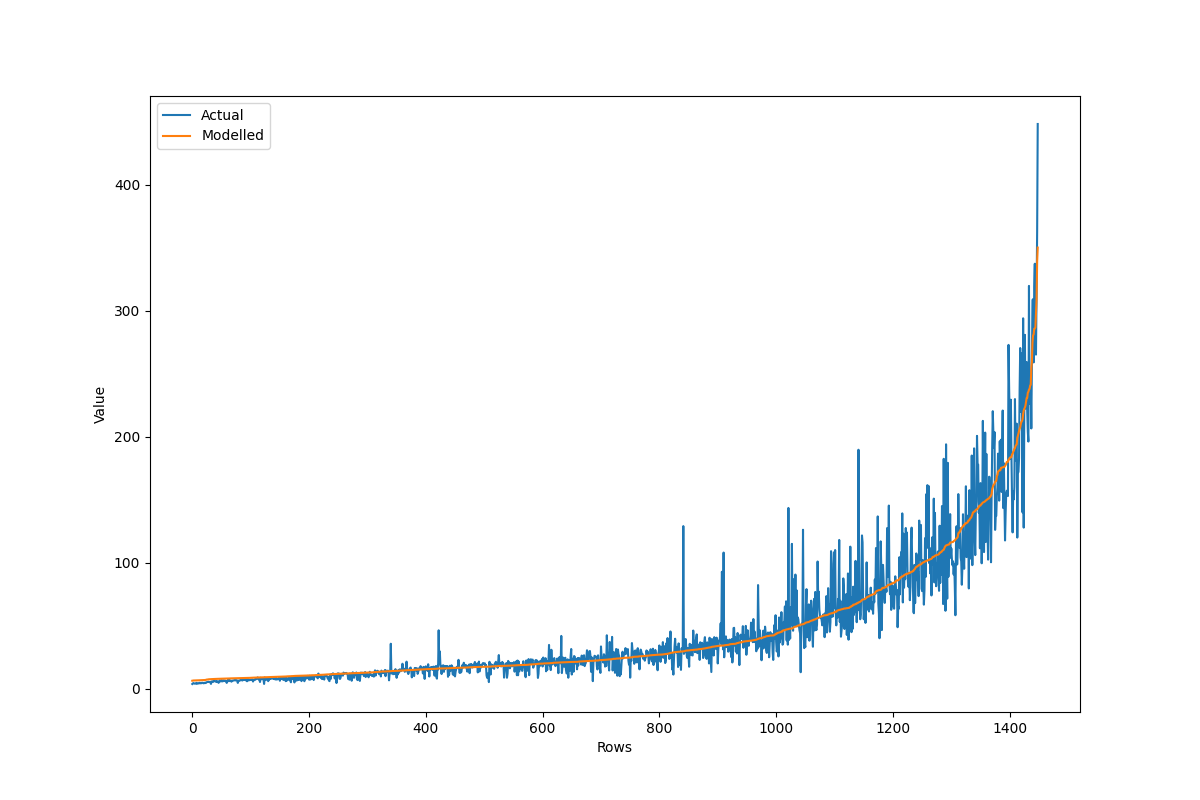

In [67]:
plt.close("all")

graph_df = outcome_df.sort_values(by=["Modelled"])
graph_df = graph_df.reset_index()
graph_df.plot(figsize=(12, 8))
plt.xlabel("Rows")
plt.ylabel("Value")

### Scatter plot of modelled vs actual values

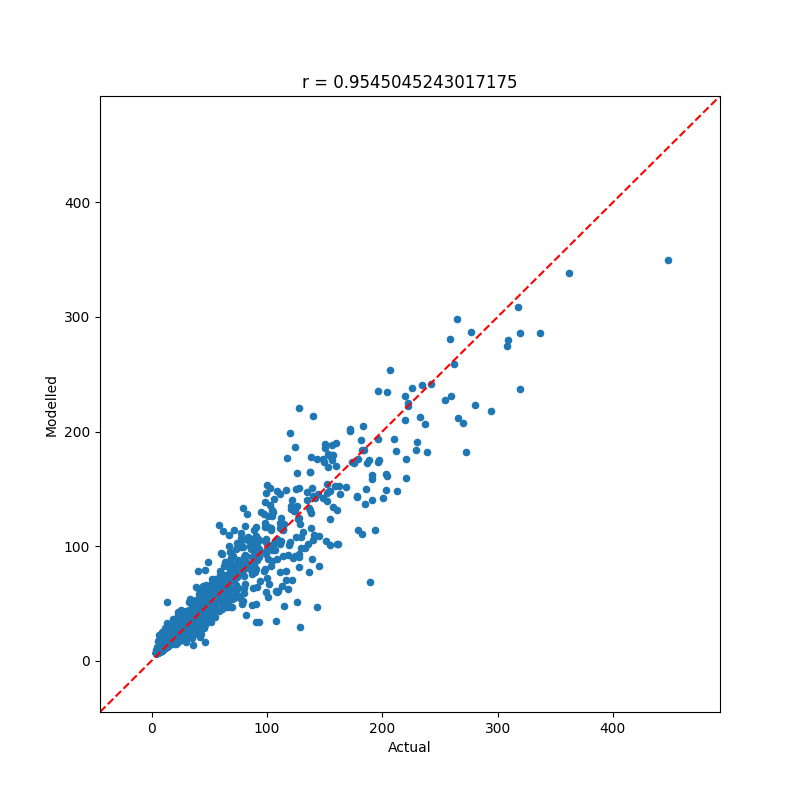

In [68]:
plt.close("all")

outcome_corr = outcome_df.corr()['Actual'].iloc[1]
lim = outcome_df["Actual"].max()

outcome_df.plot.scatter(x="Actual",
                        y="Modelled",
                        figsize=(8, 8),
                        title=f"r = {outcome_corr}",
                        xlim=(-lim * 0.1, lim * 1.1),
                        ylim=(-lim * 0.1, lim * 1.1))

plt.gca().axline((0, 0), linestyle="--", color="r", slope=1)